# ARIMA 

## Data loading and filteration

In [1]:


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import mlflow
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import  pickle




df = pd.read_csv("./ElectronicsProductsPricingData.csv", encoding='latin1')



df["prices.dateSeen"] = pd.to_datetime(df["prices.dateSeen"], errors='coerce')


# compute a percent‑discount column from the price fields
# discount_percent = ((regular_price - sale_price) / regular_price) * 100
# assume amountMax is the non‑sale price and amountMin the current price;
# guard against division by zero.

df['discount_percent'] = np.where(
    df['prices.amountMax'] > 0,
    100 * (df['prices.amountMax'] - df['prices.amountMin']) / df['prices.amountMax'],
    0
)


train = df[df["prices.dateSeen"].dt.year == 2017]
test = df[df["prices.dateSeen"].dt.year == 2018]


df_2018 = df[df["prices.dateSeen"].dt.year == 2018]
df = df[df["prices.dateSeen"].dt.year == 2017]

mlflow.end_run()


df[["discount_percent","prices.amountMax","prices.dateSeen","prices.amountMin"]].head()

/var/folders/st/r78_rxtx0hd_yr_r8qtl08_c0000gn/T/ipykernel_3946/2069459719.py:22: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["prices.dateSeen"] = pd.to_datetime(df["prices.dateSeen"], errors='coerce')


,discount_percent,prices.amountMax,prices.dateSeen,prices.amountMin
1,5.811594,69.00,2017-12-14 06:00:00+00:00,64.99
2,0.000000,69.00,2017-09-08 05:00:00+00:00,69.00
3,0.000000,69.99,2017-10-10 05:00:00+00:00,69.99
4,0.000000,66.99,2017-08-28 07:00:00+00:00,66.99
5,0.000000,66.00,2017-10-24 04:00:00+00:00,66.00


In [6]:
mlflow.end_run()

## 1. Data preparation

### 1.1 Engineer time features 

### 1.2 Create lag features 

### adf test 

In [8]:
df = df.sort_values("prices.dateSeen")
df = df.set_index("prices.dateSeen")
df_2018 = df.sort_values("prices.dateSeen")
df_2018 = df.set_index("prices.dateSeen")

daily_series = df["discount_percent"].resample("D").mean()
daily_series = daily_series.dropna()

print("Length:", len(daily_series))


result = adfuller(daily_series)

print("ADF Statistic:", result[0])
print("p-value:", result[1])

Length: 62
ADF Statistic: -3.836423750275924
p-value: 0.002555881337243172


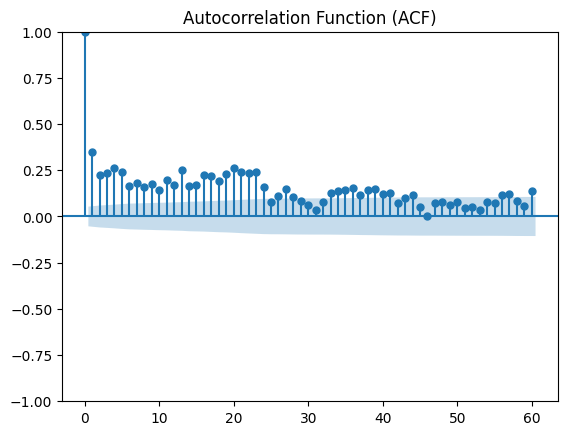

In [9]:

figure1 = plt.figure(figsize=(12, 6))
plot_acf(df_2018["discount_percent"].dropna(), lags=60)
plt.title("Autocorrelation Function (ACF)")
plt.savefig("./images/acf.png")
mlflow.log_artifact("./images/acf.png")
plt.close(figure1)

#### partial autocoorelation 
 -- here the lag 1 is the one with the highest correlation , whereas other lag 3 is alo , great too , but after lag 6, they are all below the confidence level.

In [ ]:
fig_pacf = plt.figure()
plot_pacf(df["discount_percent"].dropna(), lags=60)
plt.savefig("./images/pacf.png")
mlflow.log_artifact("./images/pacf.png")
plt.close(fig_pacf)

#### lag 1 and lag 3 

In [6]:
series = df["discount_percent"]

lag_df = pd.DataFrame({
    "current": series,
    "lag_1": series.shift(1),
    "lag_2": series.shift(2),
    "lag_14": series.shift(14),
    "lag_30": series.shift(30),
})

In [7]:
lag_df = lag_df.dropna()

In [ ]:
figure_lag_1 = plt.figure()

plt.scatter(lag_df["lag_1"], lag_df["current"], alpha=0.5)
plt.xlabel("Lag 1 (t-1)")
plt.ylabel("Current (t)")
plt.title("Lag-1 Relationship")
plt.savefig("./images/lag_1.png")
mlflow.log_artifact("./images/lag_1.png")
plt.close(figure_lag_1)


figure_lag_2 = plt.figure()
plt.figure(figsize=(6, 6))
plt.scatter(lag_df["lag_2"], lag_df["current"], alpha=0.5)
plt.xlabel("Lag 2 (t-2)")
plt.ylabel("Current (t)")
plt.title("Lag-3 Relationship")
plt.savefig("./images/lag_2.png")
mlflow.log_artifact("./images/lag_2.png")
plt.close(figure_lag_2)


#### montly and peroidic lag analysies



In [ ]:

    # ── Monthly average discount ──────────────────────────────────────────────
monthly_series = df["discount_percent"].resample("ME").mean()
monthly_series_2018 = df_2018["discount_percent"].resample("ME").mean()
fig, axes = plt.subplots(2, 1, figsize=(12, 8))
# Plot monthly mean
axes[0].plot(monthly_series.index, monthly_series.values, marker='o', linewidth=2, color='steelblue')
axes[0].plot(monthly_series_2018.index, monthly_series_2018.values, marker='o', linewidth=2, color='orange')
axes[0].set_title("Monthly Average Discount %")
axes[0].set_xlabel("Month")
axes[0].set_ylabel("Avg Discount %")
axes[0].grid(True, alpha=0.3)
axes[0].tick_params(axis='x', rotation=45)
# Month-of-year box plot (seasonality)
monthly_df = df["discount_percent"].copy().reset_index()
monthly_df.columns = ["date", "discount_percent"]
monthly_df["month"] = monthly_df["date"].dt.month
monthly_df["month_name"] = monthly_df["date"].dt.strftime("%b")
month_order = ["Jan","Feb","Mar","Apr","May","Jun",
            "Jul","Aug","Sep","Oct","Nov","Dec"]
monthly_df["month_name"] = pd.Categorical(monthly_df["month_name"], categories=month_order, ordered=True)
monthly_df_clean = monthly_df.dropna(subset=["month_name"])
monthly_df_clean.boxplot(column="discount_percent", by="month_name",
                        ax=axes[1], grid=False)
axes[1].set_title("Discount % Distribution by Month")
axes[1].set_xlabel("Month")
axes[1].set_ylabel("Discount %")
plt.suptitle("")
plt.tight_layout()
plt.show()

In [ ]:

    # ── Lag-14 and Lag-30 scatter plots (weekly / monthly lags) ───────────────
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].scatter(lag_df["lag_14"], lag_df["current"], alpha=0.4, color='steelblue')
axes[0].set_xlabel("Lag 14 (t-14)")
axes[0].set_ylabel("Current (t)")
axes[0].set_title("Lag-14 Relationship (~2 weeks)")
axes[0].grid(True, alpha=0.3)
axes[1].scatter(lag_df["lag_30"], lag_df["current"], alpha=0.4, color='darkorange')
axes[1].set_xlabel("Lag 30 (t-30)")
axes[1].set_ylabel("Current (t)")
axes[1].set_title("Lag-30 Relationship (~1 month)")
axes[1].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
# ── Lag correlation summary table ─────────────────────────────────────────
# Use lag_df which already has duplicates removed via dropna/shift alignment

lag_df["lag_7"] = lag_df["current"].shift(7)
lag_df_clean = lag_df.dropna()

lag_corr = pd.DataFrame({
    "lag": [1, 2, 7, 14, 30],
    "pearson_r": [
        lag_df_clean["lag_1"].corr(lag_df_clean["current"]),
        lag_df_clean["lag_2"].corr(lag_df_clean["current"]),
        lag_df_clean["lag_7"].corr(lag_df_clean["current"]),
        lag_df_clean["lag_14"].corr(lag_df_clean["current"]),
        lag_df_clean["lag_30"].corr(lag_df_clean["current"]),
    ]
})

fig, ax = plt.subplots(figsize=(7, 4))
colors = ['steelblue' if r > 0.1 else 'lightgray' for r in lag_corr["pearson_r"]]
bars = ax.bar([f"Lag {l}" for l in lag_corr["lag"]], lag_corr["pearson_r"], color=colors)
ax.axhline(0.1, color='red', linestyle='--', linewidth=1, label='0.1 threshold')
ax.set_title("Pearson Correlation: Lag vs Current Discount %")
ax.set_ylabel("Pearson r")
ax.set_xlabel("Lag")
ax.legend()
ax.grid(True, axis='y', alpha=0.3)
for bar, val in zip(bars, lag_corr["pearson_r"]):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.002,
            f"{val:.3f}", ha='center', va='bottom', fontsize=9)
    
plt.savefig("./images/Pearson_Correlation(Lag_vs_Current_Discount).png")
mlflow.log_artifact("./images/Pearson_Correlation(Lag_vs_Current_Discount).png")
plt.tight_layout()
plt.show()

print(lag_corr.to_string(index=False))


### 1.3 Handle =% discount - build two stage model

### 1.4 Train/test split: 2017 = train, 2018 = test

 - we will split the dat series into two different forms 
 - **2017** - Train for the data 
 - **2018** - Testing the model

## ARIMA model
The **ARIMA** model consists of three different values , the p(Autoregressive), d(differencing), q(movig average)
 - **Autoregressive** - it refers to the relationship between the current value and the past vlaues of the sam variable.
 - **Integration** - it refers to the gegree of differcing applied to the data to make it stationary. 
 - **Moving Average** - it refers to the relationship between the current value and the past errors of the model. 

From the above data filtering , we have p value either 1, 2,3 or 4 , now for the q value , for the q value , since we from the above ADF test , we get the p-value less then 0.05 , which makes the series to be stationary , d value is 0 , but if the series was greater then 0.05 , then we have to 

In [2]:



train = train.sort_values("prices.dateSeen")
train = train.set_index("prices.dateSeen")



test = test.sort_values("prices.dateSeen")
test = test.set_index("prices.dateSeen")



train.head()

,id,prices.amountMax,prices.amountMin,prices.availability,prices.condition,prices.currency,prices.isSale,prices.merchant,prices.shipping,prices.sourceURLs,...,primaryCategories,sourceURLs,upc,weight,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,discount_percent
prices.dateSeen,,,,,,,,,,,,,,,,,,,,,
2017-03-02 22:00:00+00:00,AVpi9AE_LJeJML43qkYJ,159.98,159.98,Yes,New,USD,False,Bestbuy.com,NaN,http://www.bestbuy.com/site/panamax-8-outlet-s...,...,Electronics,https://reviews.bestbuy.com/3545/5587713/revie...,50616008921,6.5 pounds,NaN,NaN,NaN,NaN,NaN,0.0
2017-03-02 22:00:00+00:00,AVpikPJcLJeJML43m5wF,486.99,486.99,Yes,New,USD,True,Bestbuy.com,NaN,http://www.bestbuy.com/site/denon-1295w-7-2-ch...,...,Electronics,http://www.walmart.com/ip/7-2CH-AVR-WITH-WIFI-...,"883,795,003,827,636,000,000,000",24.3 pounds,NaN,NaN,NaN,NaN,NaN,0.0
2017-03-02 22:00:00+00:00,AVpiE9hhilAPnD_xAfSU,48.99,48.99,Yes,New,USD,False,Bestbuy.com,NaN,http://www.bestbuy.com/site/samsung-evo-128gb-...,...,Electronics,http://reviews.bestbuy.com/3545/5410400/review...,"887,276,079,868,887,000,000,000",0.16 ounces ...,NaN,NaN,NaN,NaN,NaN,0.0
2017-03-03 14:00:00+00:00,AVphpDVCilAPnD_x7rUn,108.99,108.99,Yes,New,USD,False,Bestbuy.com,NaN,http://www.bestbuy.com/site/siriusxm-sd2-porta...,...,Electronics,http://www.frys.com/product/9149648?site=sr:SE...,8.85E+11,11.35 pounds,NaN,NaN,NaN,NaN,NaN,0.0
2017-03-04 03:00:00+00:00,AVpgDPRjilAPnD_xmpMU,168.99,168.99,Yes,New,USD,True,Bestbuy.com,NaN,http://www.bestbuy.com/site/yamaha-musiccast-w...,...,Electronics,https://www.amazon.com/Yamaha-WX-030BL-MusicCa...,27108952628,3 pounds,NaN,NaN,NaN,NaN,NaN,0.0


In [3]:
mlflow.set_experiment("ARIMA_Discount_Model")

for p in range(3):
    for d in range(2):
        for q in range(3):

            with mlflow.start_run():

                mlflow.log_param("p", p)
                mlflow.log_param("d", d)
                mlflow.log_param("q", q)

                model = ARIMA(train["discount_percent"], order=(p,d,q))
                model_fit = model.fit()

                forecast = model_fit.forecast(len(test))
                
                rmse = np.sqrt(mean_squared_error(test["discount_percent"], forecast))

                mlflow.log_metric("rmse", rmse)
                mlflow.log_metric("aic", model_fit.aic)

                # save model
                import pickle
                with open("arima.pkl", "wb") as f:
                    pickle.dump(model_fit, f)

                mlflow.log_artifact("arima.pkl")

/Users/ayushghimire/Documents/GitHub/jupyter-lab-models/arima/lib/python3.14/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/ayushghimire/Documents/GitHub/jupyter-lab-models/arima/lib/python3.14/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/ayushghimire/Documents/GitHub/jupyter-lab-models/arima/lib/python3.14/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/ayushghimire/Documents/GitHub/jupyter-lab-models/arima/lib/python3.14/site-packages/statsm

In [ ]:
forecast.head()